In [3]:
import numpy as np
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [24]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots'
my_data_dir = proj_dir + '/my_data'
nb_dir = proj_dir + '/notebooks'

In [70]:
## Which vertical columns are we considering here?
which_columns = {
  'lons' : [-174.5, 45.5, 75.5, -129.5, 160.5],
  'lats' : [-29.5, -59.5, -24.5, 0.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific', 'southern_ocean', 'indian_ocean', 'tropical_pacific', 'north_pacific']
}
sergey_columns = {
  'lons' : [-150.0, 160.0, 75.0,  -110.0],
  'lats' : [3.0,    40.0,  -24.0, -30.0],
  'name' : ['Tropical East Pacific', 'Kuroshio', 'Indian Ocean', 'South Pacific'],
  'save_name' : ['tepac', 'kuroshio', 'io', 'spac']
}

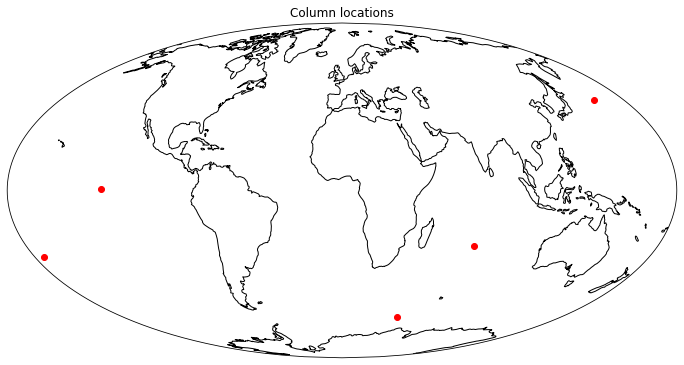

In [175]:
## Save a map of the world showing column locations
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_global()
plt.title('Column locations')
ax.coastlines(resolution='110m')
ax.scatter(which_columns['lons'], which_columns['lats'], c='r',transform=ccrs.PlateCarree())
plt.rcParams['figure.figsize'] = [8,4]
plt.savefig(plot_dir+'/column_locations.png')
plt.show()

In [75]:
## Load vertical columns
south_pacific = xr.open_dataset(my_data_dir+'/five_columns_south_pacific.nc')
southern_ocean = xr.open_dataset(my_data_dir+'/five_columns_southern_ocean.nc')
indian_ocean = xr.open_dataset(my_data_dir+'/five_columns_indian_ocean.nc')
tropical_pacific = xr.open_dataset(my_data_dir+'/five_columns_tropical_pacific.nc')
north_pacific = xr.open_dataset(my_data_dir+'/five_columns_north_pacific.nc')

In [76]:
## Take a look at one of these datasets
south_pacific

<xarray.Dataset>
Dimensions:           (lon: 5, lat: 5, atm_lev: 64, atm_lay: 4, atm_hor: 1, ocn_lev: 75, ice_cat: 5, ens_mem: 80)
Coordinates:
  * lon               (lon) float32 183.5 184.5 185.5 186.5 187.5
  * lat               (lat) float32 -31.5 -30.5 -29.5 -28.5 -27.5
  * atm_lev           (atm_lev) float32 0.0 1.0 2.0 3.0 ... 60.0 61.0 62.0 63.0
  * atm_lay           (atm_lay) float32 0.0 1.0 2.0 3.0
  * atm_hor           (atm_hor) float32 0.0
  * ocn_lev           (ocn_lev) float32 1.0 3.0 5.0 ... 3.591e+03 5.111e+03
  * ice_cat           (ice_cat) float32 0.0 1.0 2.0 3.0 4.0
  * ens_mem           (ens_mem) int64 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79
Data variables: (12/138)
    atm_u             (ens_mem, atm_lev, lat, lon) float32 ...
    atm_v             (ens_mem, atm_lev, lat, lon) float32 ...
    atm_W             (ens_mem, atm_lev, lat, lon) float32 ...
    atm_DZ            (ens_mem, atm_lev, lat, lon) float32 ...
    atm_T             (ens_mem, atm_lev, lat, lon) float32 ...
    atm_delp          (ens_mem, atm_lev, lat, lon) float32 ...
    ...                ...
    ice_qice006       (ens_mem, ocn_lev, lat, lon) float32 ...
    ice_sice007       (ens_mem, ocn_lev, lat, lon) float32 ...
    ice_qice007       (ens_mem, ocn_lev, lat, lon) float32 ...
    ice_qsno001       (ens_mem, ocn_lev, lat, lon) float32 ...
    wind_spd          (ens_mem, lat, lon) float32 ...
    sst               (ens_mem, lat, lon) float32 ...
Attributes:
    filename:  /work/noaa/gsienkf/weihuang/jedi/case_study/bump/tmplatlondata...
    title:     Atmosphere, Ocean and Ice combined data

In [109]:
## Compute correlation between sst and atm/ocn temperature
sp_corr = xr.Dataset()
sp_corr['sst_atm_T'] = xr.corr(south_pacific['sst'], south_pacific['atm_T'], dim = 'ens_mem')
sp_corr['sst_ocn_T'] = xr.corr(south_pacific['sst'], south_pacific['ocn_Temp'], dim = 'ens_mem')
sp_corr['atm_p'] = south_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
sp_corr = sp_corr.mean(['lat', 'lon'])

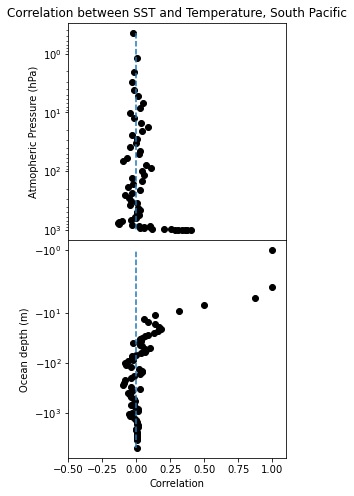

In [145]:
## Collect variables to plot
name = 'South Pacific'
ds = sp_corr
atm_var = 'sst_atm_T'
ocn_var = 'sst_ocn_T'
plt_atm_x = ds[atm_var]
plt_atm_y = ds['atm_p']
plt_ocn_x = ds[ocn_var]
plt_ocn_y = -1 * ds['ocn_lev']

## Create subplots
fig, axs = plt.subplots(nrows=2, sharex=True) 

# Plot atm variable
axs[0].plot(plt_atm_x, plt_atm_y, 'ko')
axs[0].invert_yaxis()
axs[0].set_yscale('log')
axs[0].set_xlim([-0.5, 1.1])
axs[0].set_ylabel('Atmopheric Pressure (hPa)')
axs[0].vlines(x=0, ymin=plt_atm_y.min(), ymax = plt_atm_y.max(), linestyles='dashed')

# Plot ocn variable
axs[1].plot(plt_ocn_x, plt_ocn_y, 'ko')
axs[1].vlines(x=0, ymin=plt_ocn_y.min(), ymax = plt_ocn_y.max(), linestyles='dashed')
axs[1].set_ylabel('Ocean depth (m)')
axs[1].set_yscale('symlog')

axs[1].set_xlabel('Correlation')
axs[0].set_title('Correlation between SST and Temperature, '+name)

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
axs[0].grid()
axs[0].grid()
axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)
plt.rcParams['figure.figsize'] = [6,8]
plt.savefig(plot_dir+'/sst_temp_corr_south_pacific')
plt.show()

In [167]:
## South Pacific
sp_corr = xr.Dataset()
sp_corr['sst_atm_T'] = xr.corr(south_pacific['sst'], south_pacific['atm_T'], dim = 'ens_mem')
sp_corr['sst_ocn_T'] = xr.corr(south_pacific['sst'], south_pacific['ocn_Temp'], dim = 'ens_mem')
sp_corr['atm_p'] = south_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
sp_corr = sp_corr.mean(['lat', 'lon'])

## Southern Ocean
so_corr = xr.Dataset()
so_corr['sst_atm_T'] = xr.corr(southern_ocean['sst'], southern_ocean['atm_T'], dim = 'ens_mem')
so_corr['sst_ocn_T'] = xr.corr(southern_ocean['sst'], southern_ocean['ocn_Temp'], dim = 'ens_mem')
so_corr['atm_p'] = southern_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
so_corr = so_corr.mean(['lat', 'lon'])

## Indian Ocean
io_corr = xr.Dataset()
io_corr['sst_atm_T'] = xr.corr(indian_ocean['sst'], indian_ocean['atm_T'], dim = 'ens_mem')
io_corr['sst_ocn_T'] = xr.corr(indian_ocean['sst'], indian_ocean['ocn_Temp'], dim = 'ens_mem')
io_corr['atm_p'] = indian_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
io_corr = io_corr.mean(['lat', 'lon'])

## Tropical Pacific
tp_corr = xr.Dataset()
tp_corr['sst_atm_T'] = xr.corr(tropical_pacific['sst'], tropical_pacific['atm_T'], dim = 'ens_mem')
tp_corr['sst_ocn_T'] = xr.corr(tropical_pacific['sst'], tropical_pacific['ocn_Temp'], dim = 'ens_mem')
tp_corr['atm_p'] = tropical_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
tp_corr = tp_corr.mean(['lat', 'lon'])

## North Pacific
np_corr = xr.Dataset()
np_corr['sst_atm_T'] = xr.corr(north_pacific['sst'], north_pacific['atm_T'], dim = 'ens_mem')
np_corr['sst_ocn_T'] = xr.corr(north_pacific['sst'], north_pacific['ocn_Temp'], dim = 'ens_mem')
np_corr['atm_p'] = north_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
np_corr = np_corr.mean(['lat', 'lon'])

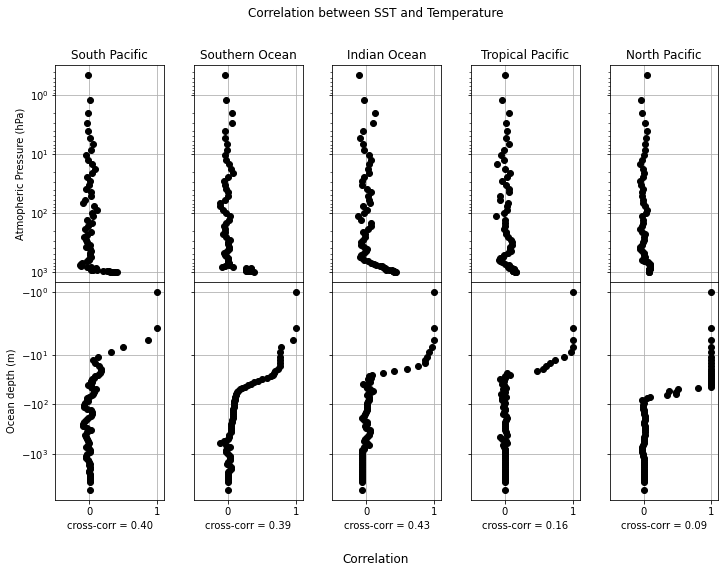

In [174]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='row') 

# Plot atm correlations
axs[0, 0].plot(sp_corr['sst_atm_T'], sp_corr['atm_p'], 'ko')
axs[0, 1].plot(so_corr['sst_atm_T'], so_corr['atm_p'], 'ko')
axs[0, 2].plot(io_corr['sst_atm_T'], io_corr['atm_p'], 'ko')
axs[0, 3].plot(tp_corr['sst_atm_T'], tp_corr['atm_p'], 'ko')
axs[0, 4].plot(np_corr['sst_atm_T'], np_corr['atm_p'], 'ko')

# Plot ocn correlations
axs[1, 0].plot(sp_corr['sst_ocn_T'], -1 * sp_corr['ocn_lev'], 'ko')
axs[1, 1].plot(so_corr['sst_ocn_T'], -1 * so_corr['ocn_lev'], 'ko')
axs[1, 2].plot(io_corr['sst_ocn_T'], -1 * io_corr['ocn_lev'], 'ko')
axs[1, 3].plot(tp_corr['sst_ocn_T'], -1 * tp_corr['ocn_lev'], 'ko')
axs[1, 4].plot(np_corr['sst_ocn_T'], -1 * np_corr['ocn_lev'], 'ko')

# Set titles
axs[0,0].set_title('South Pacific')
axs[0,1].set_title('Southern Ocean')
axs[0,2].set_title('Indian Ocean')
axs[0,3].set_title('Tropical Pacific')
axs[0,4].set_title('North Pacific')

# Add correlation
axs[1,0].set_xlabel('cross-corr = '+str('%.2f'%sp_corr['sst_atm_T'][63].values))
axs[1,1].set_xlabel('cross-corr = '+str('%.2f'%so_corr['sst_atm_T'][63].values))
axs[1,2].set_xlabel('cross-corr = '+str('%.2f'%io_corr['sst_atm_T'][63].values))
axs[1,3].set_xlabel('cross-corr = '+str('%.2f'%tp_corr['sst_atm_T'][63].values))
axs[1,4].set_xlabel('cross-corr = '+str('%.2f'%np_corr['sst_atm_T'][63].values))

# Adjust axes
axs[0, 0].invert_yaxis()
axs[0, 0].set_yscale('log')
axs[1, 0].set_yscale('symlog')

# Adjust and label axes
axs[0, 0].set_xlim([-0.5, 1.1])
axs[0, 0].set_ylabel('Atmopheric Pressure (hPa)')
axs[1, 0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Correlation')
fig.suptitle('Correlation between SST and Temperature')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/sst_temp_corr_five_columns')
plt.show()

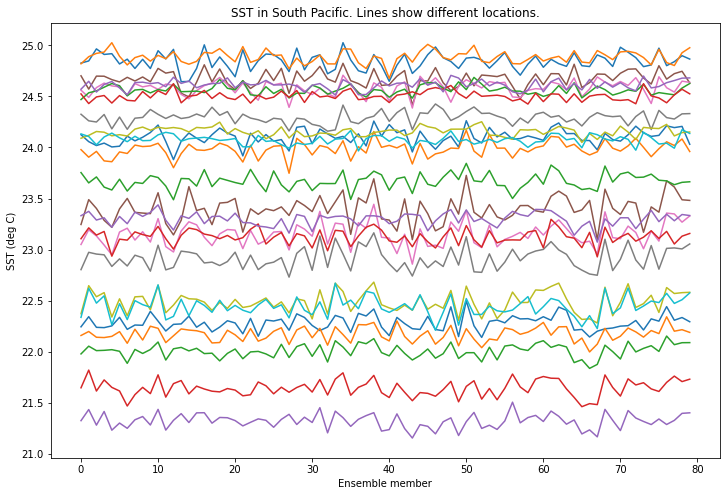

In [237]:
sp_sst = south_pacific['sst'].to_numpy()
sp_sst = sp_sst.reshape(80, 25)
plt.plot(sp_sst)
plt.title('SST in South Pacific. Lines show different locations.')
plt.ylabel('SST (deg C)')
plt.xlabel('Ensemble member')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/sst_by_ens_mem_south_pacific')
plt.show()

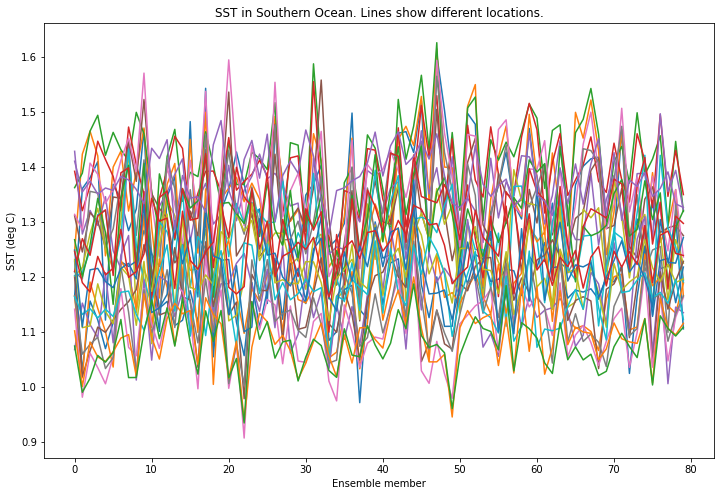

In [239]:
so_sst = southern_ocean['sst'].to_numpy()
so_sst = so_sst.reshape(80, 25)
plt.plot(so_sst)
plt.title('SST in Southern Ocean. Lines show different locations.')
plt.ylabel('SST (deg C)')
plt.xlabel('Ensemble member')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/sst_by_ens_mem_southern_ocean')
plt.show()

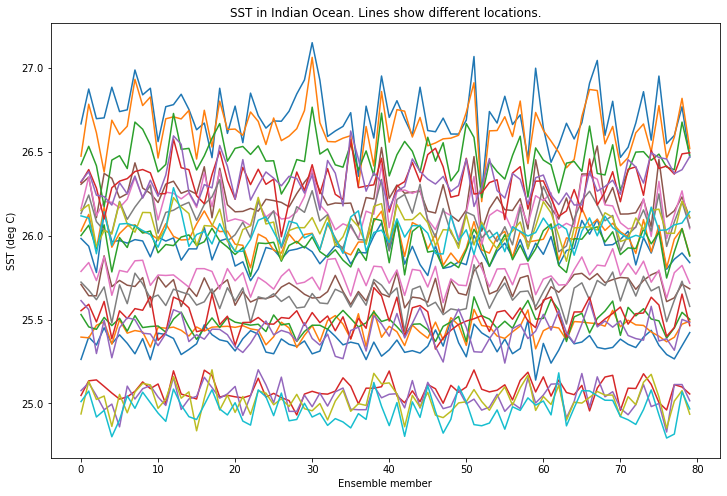

In [240]:
io_sst = indian_ocean['sst'].to_numpy()
io_sst = io_sst.reshape(80, 25)
plt.plot(io_sst)
plt.title('SST in Indian Ocean. Lines show different locations.')
plt.ylabel('SST (deg C)')
plt.xlabel('Ensemble member')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/sst_by_ens_mem_indian_ocean')
plt.show()

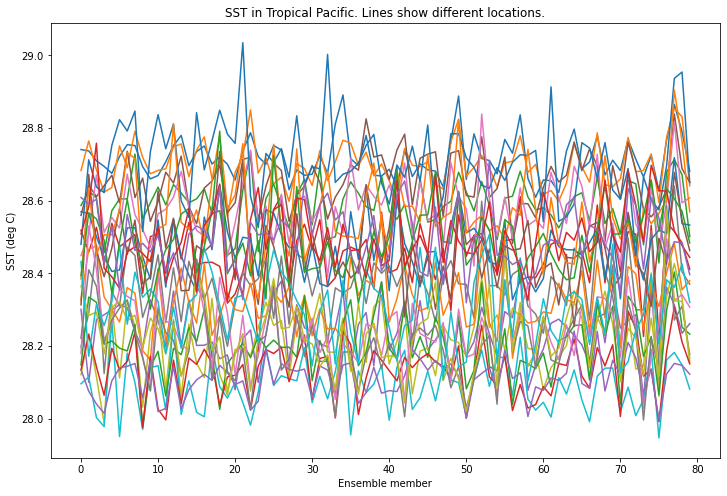

In [241]:
tp_sst = tropical_pacific['sst'].to_numpy()
tp_sst = tp_sst.reshape(80, 25)
plt.plot(tp_sst)
plt.title('SST in Tropical Pacific. Lines show different locations.')
plt.ylabel('SST (deg C)')
plt.xlabel('Ensemble member')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/sst_by_ens_mem_tropical_pacific')
plt.show()

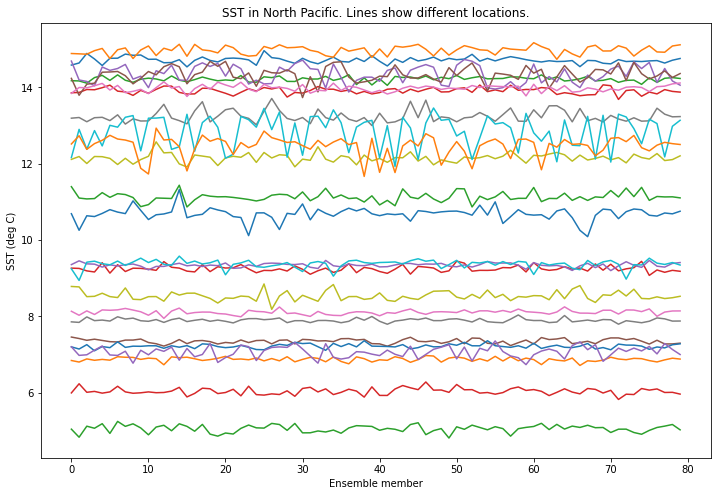

In [242]:
np_sst = north_pacific['sst'].to_numpy()
np_sst = np_sst.reshape(80, 25)
plt.plot(np_sst)
plt.title('SST in North Pacific. Lines show different locations.')
plt.ylabel('SST (deg C)')
plt.xlabel('Ensemble member')
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/sst_by_ens_mem_north_pacific')
plt.show()

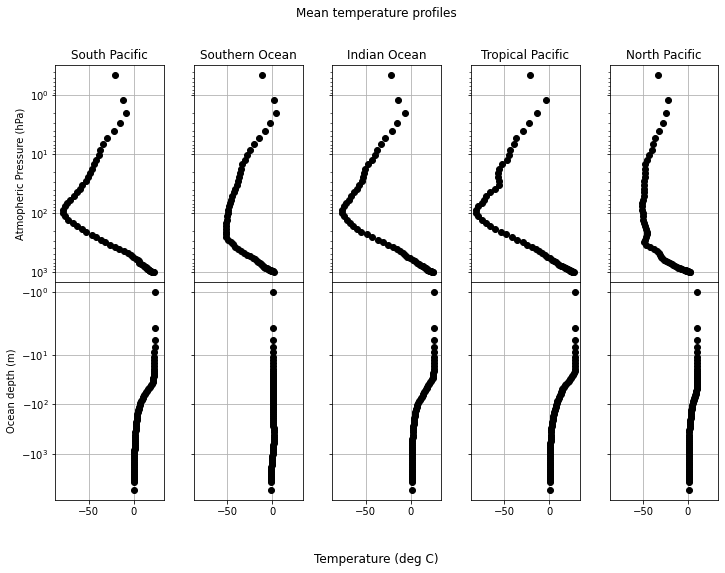

In [251]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='row') 

# Plot atm temperature
axs[0, 0].plot(south_pacific['atm_T'].mean(['lat', 'lon', 'ens_mem'])-273.15, sp_corr['atm_p'], 'ko')
axs[0, 1].plot(southern_ocean['atm_T'].mean(['lat', 'lon', 'ens_mem'])-273.15, so_corr['atm_p'], 'ko')
axs[0, 2].plot(indian_ocean['atm_T'].mean(['lat', 'lon', 'ens_mem'])-273.15, io_corr['atm_p'], 'ko')
axs[0, 3].plot(tropical_pacific['atm_T'].mean(['lat', 'lon', 'ens_mem'])-273.15, tp_corr['atm_p'], 'ko')
axs[0, 4].plot(north_pacific['atm_T'].mean(['lat', 'lon', 'ens_mem'])-273.15, np_corr['atm_p'], 'ko')

# Plot ocn temperature
axs[1, 0].plot(south_pacific['ocn_Temp'].mean(['lat', 'lon', 'ens_mem']), -1 * sp_corr['ocn_lev'], 'ko')
axs[1, 1].plot(southern_ocean['ocn_Temp'].mean(['lat', 'lon', 'ens_mem']), -1 * so_corr['ocn_lev'], 'ko')
axs[1, 2].plot(indian_ocean['ocn_Temp'].mean(['lat', 'lon', 'ens_mem']), -1 * io_corr['ocn_lev'], 'ko')
axs[1, 3].plot(tropical_pacific['ocn_Temp'].mean(['lat', 'lon', 'ens_mem']), -1 * tp_corr['ocn_lev'], 'ko')
axs[1, 4].plot(north_pacific['ocn_Temp'].mean(['lat', 'lon', 'ens_mem']), -1 * np_corr['ocn_lev'], 'ko')

# Set titles
axs[0,0].set_title('South Pacific')
axs[0,1].set_title('Southern Ocean')
axs[0,2].set_title('Indian Ocean')
axs[0,3].set_title('Tropical Pacific')
axs[0,4].set_title('North Pacific')

# Adjust axes
axs[0, 0].invert_yaxis()
axs[0, 0].set_yscale('log')
axs[1, 0].set_yscale('symlog')

# Adjust and label axes
#axs[0, 0].set_xlim([-0.5, 1.1])
axs[0, 0].set_ylabel('Atmopheric Pressure (hPa)')
axs[1, 0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Temperature (deg C)')
fig.suptitle('Mean temperature profiles')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_mean_atm_ocn_five_columns')
plt.show()

In [268]:
## Plot vertical profiles in top 150 m of ocean
## Average over ensemble members and show the mean at each location only

# South Pacific
sp_temp = south_pacific['ocn_Temp'].mean('ens_mem').to_numpy()
sp_temp = sp_temp.reshape(75, 25)

# Southern Ocean
so_temp = southern_ocean['ocn_Temp'].mean('ens_mem').to_numpy()
so_temp = so_temp.reshape(75, 25)

# Indian Ocean
io_temp = indian_ocean['ocn_Temp'].mean('ens_mem').to_numpy()
io_temp = io_temp.reshape(75, 25)

# Tropical Pacific
tp_temp = tropical_pacific['ocn_Temp'].mean('ens_mem').to_numpy()
tp_temp = tp_temp.reshape(75, 25)

# North Pacific
np_temp = north_pacific['ocn_Temp'].mean('ens_mem').to_numpy()
np_temp = np_temp.reshape(75, 25)

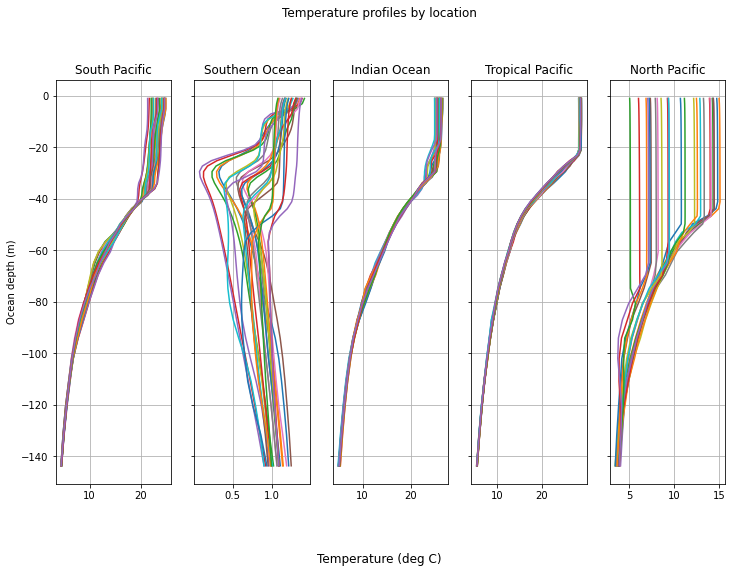

In [275]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True) 

# Plot ocn temperature
ind150m =  37
axs[0].plot(sp_temp[:ind150m], -1 * sp_corr['ocn_lev'][:ind150m])
axs[1].plot(so_temp[:ind150m], -1 * so_corr['ocn_lev'][:ind150m])
axs[2].plot(io_temp[:ind150m], -1 * io_corr['ocn_lev'][:ind150m])
axs[3].plot(tp_temp[:ind150m], -1 * tp_corr['ocn_lev'][:ind150m])
axs[4].plot(np_temp[:ind150m], -1 * np_corr['ocn_lev'][:ind150m])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Temperature (deg C)')
fig.suptitle('Temperature profiles by location')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_mean_ocn150m_five_columns')
plt.show()

In [284]:
## Plot spread in top 150 m of ocean
## Standard deviation of ensemble

# South Pacific
sp_temp_std = south_pacific['ocn_Temp'].std('ens_mem').to_numpy()
sp_temp_std = sp_temp_std.reshape(75, 25)

# Southern Ocean
so_temp_std = southern_ocean['ocn_Temp'].std('ens_mem').to_numpy()
so_temp_std = so_temp_std.reshape(75, 25)

# Indian Ocean
io_temp_std = indian_ocean['ocn_Temp'].std('ens_mem').to_numpy()
io_temp_std = io_temp_std.reshape(75, 25)

# Tropical Pacific
tp_temp_std = tropical_pacific['ocn_Temp'].std('ens_mem').to_numpy()
tp_temp_std = tp_temp_std.reshape(75, 25)

# North Pacific
np_temp_std = north_pacific['ocn_Temp'].std('ens_mem').to_numpy()
np_temp_std = np_temp_std.reshape(75, 25)

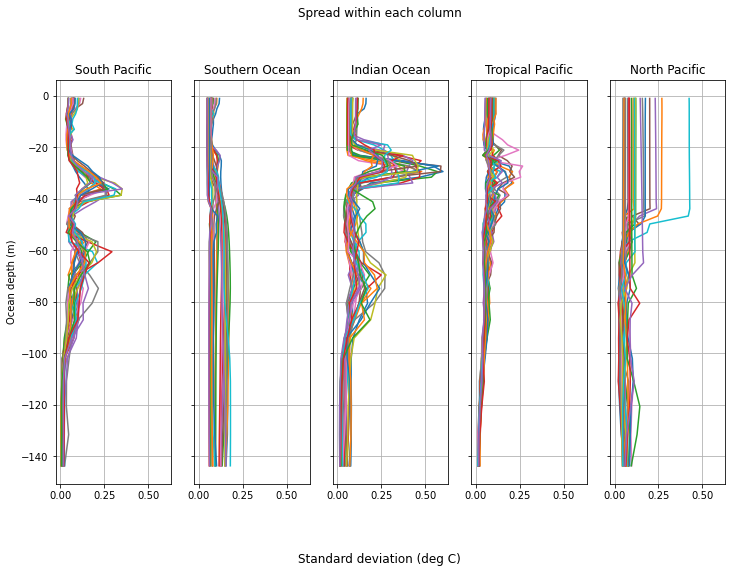

In [286]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot ocn temperature
ind150m =  37
axs[0].plot(sp_temp_std[:ind150m], -1 * sp_corr['ocn_lev'][:ind150m])
axs[1].plot(so_temp_std[:ind150m], -1 * so_corr['ocn_lev'][:ind150m])
axs[2].plot(io_temp_std[:ind150m], -1 * io_corr['ocn_lev'][:ind150m])
axs[3].plot(tp_temp_std[:ind150m], -1 * tp_corr['ocn_lev'][:ind150m])
axs[4].plot(np_temp_std[:ind150m], -1 * np_corr['ocn_lev'][:ind150m])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread within each column')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_std_bycolumn_ocn150m_five_columns')
plt.show()

In [290]:
# Spread in the mean profiles
sp_stdofmean = sp_temp.std(axis=1)
so_stdofmean = so_temp.std(axis=1)
io_stdofmean = io_temp.std(axis=1)
tp_stdofmean = tp_temp.std(axis=1)
np_stdofmean = np_temp.std(axis=1)

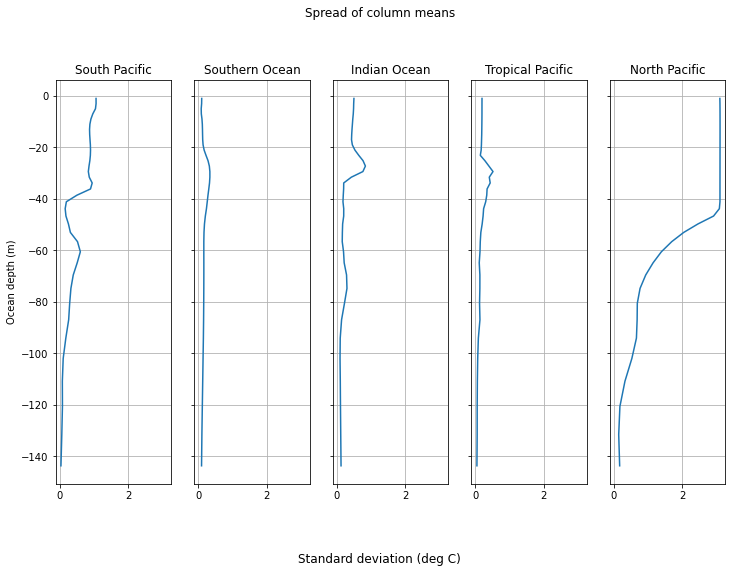

In [291]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot ocn temperature
ind150m =  37
axs[0].plot(sp_stdofmean[:ind150m], -1 * sp_corr['ocn_lev'][:ind150m])
axs[1].plot(so_stdofmean[:ind150m], -1 * so_corr['ocn_lev'][:ind150m])
axs[2].plot(io_stdofmean[:ind150m], -1 * io_corr['ocn_lev'][:ind150m])
axs[3].plot(tp_stdofmean[:ind150m], -1 * tp_corr['ocn_lev'][:ind150m])
axs[4].plot(np_stdofmean[:ind150m], -1 * np_corr['ocn_lev'][:ind150m])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread of column means')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_stdofmean_ocn150m_five_columns')
plt.show()

In [309]:
## Convert dataset to numpy array in an ugly loop
# which location
ds = north_pacific
name = 'north_pacific'

num_atm_lev = len(ds['atm_lev'])
num_ocn_lev = len(ds['ocn_lev'])
num_tot_lev =  num_atm_lev + num_ocn_lev
num_ens_mem = len(ds['ens_mem'])
num_bs_ens_mem = num_ens_mem * 25
ds_manual = np.empty((num_tot_lev, num_bs_ens_mem))
start = 0
end = num_ens_mem
for lon in ds['lon'].values:
  for lat in ds['lat'].values:
    # Select atm columns
    ds_atm = ds['atm_T'].sel(lon=lon, lat=lat)
    ds_atm_np = ds_atm.to_numpy()
    ds_atm_np = np.swapaxes(ds_atm_np, 0, 1)
    ens_atm_avg = ds_atm_np.mean(axis=1)
    ens_atm_avg_expand = np.tile(ens_atm_avg, (num_ens_mem,1)).transpose()
    # Select ocn columns
    ds_ocn = ds['ocn_Temp'].sel(lon=lon, lat=lat, method='nearest')
    ds_ocn_np = ds_ocn.to_numpy()
    ds_ocn_np = np.swapaxes(ds_ocn_np, 0, 1)
    ens_ocn_avg = ds_ocn_np.mean(axis=1)
    ens_ocn_avg_expand = np.tile(ens_ocn_avg, (num_ens_mem,1)).transpose()
    # Store atm and ocn columns
    ds_manual[:num_atm_lev , start:end] = ds_atm_np - ens_atm_avg_expand
    ds_manual[num_atm_lev:num_tot_lev , start:end] = ds_ocn_np - ens_ocn_avg_expand
    start = start + num_ens_mem
    end = end + num_ens_mem

## Compute covariance matrix
cov_temp = np.cov(ds_manual)
cor_temp = np.corrcoef(ds_manual)

## Save covariance and correlation matrices
np.save(my_data_dir+'/'+name+'_cov.npy', cov_temp)
np.save(my_data_dir+'/'+name+'_cor.npy', cor_temp)

/Users/zstanley/.conda/envs/favorite/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/zstanley/.conda/envs/favorite/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/zstanley/.conda/envs/favorite/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/zstanley/.conda/envs/favorite/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated

In [310]:
# Load covariance matrices
sp_cov = np.load(my_data_dir +'/south_pacific_cov.npy')
so_cov = np.load(my_data_dir +'/southern_ocean_cov.npy')
io_cov = np.load(my_data_dir +'/indian_ocean_cov.npy')
tp_cov = np.load(my_data_dir +'/tropical_pacific_cov.npy')
np_cov = np.load(my_data_dir +'/north_pacific_cov.npy')

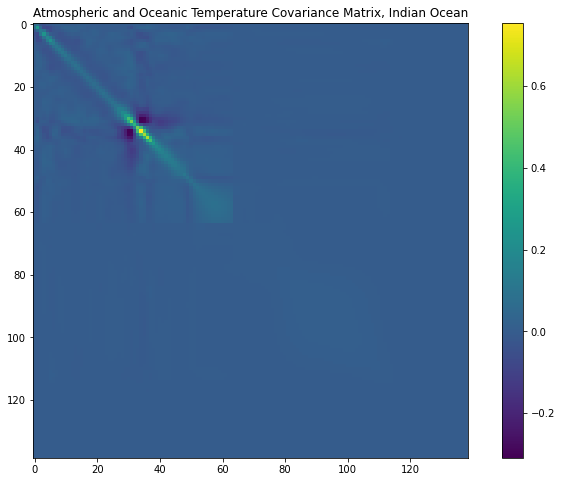

In [347]:
# Plot covariance matrices
this_cov = so_cov
fullname = 'Indian Ocean'
short_name = 'indian_ocean'
plt.imshow(this_cov)
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Covariance Matrix, '+fullname)
plt.savefig(plot_dir+'/cov_atm_ocn_temperature_'+short_name+'.png')

In [321]:
# Load correlation matrices
sp_cor = np.load(my_data_dir +'/south_pacific_cor.npy')
so_cor = np.load(my_data_dir +'/southern_ocean_cor.npy')
io_cor = np.load(my_data_dir +'/indian_ocean_cor.npy')
tp_cor = np.load(my_data_dir +'/tropical_pacific_cor.npy')
np_cor = np.load(my_data_dir +'/north_pacific_cor.npy')

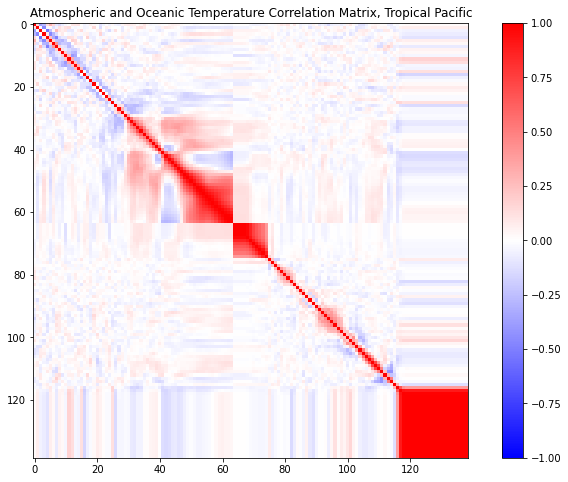

In [342]:
# Plot correlation matrices
this_cor = tp_cor
fullname = 'Tropical Pacific'
short_name = 'tropical_pacific'
plt.imshow(this_cor,  vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.title('Atmospheric and Oceanic Temperature Correlation Matrix, '+fullname)
plt.savefig(plot_dir+'/cor_atm_ocn_temperature_'+short_name+'.png')

In [348]:
# Plot spread by vertical level in the ocean, to 150 m
sp_spread = np.sqrt(np.diag(sp_cov))
so_spread = np.sqrt(np.diag(so_cov))
io_spread = np.sqrt(np.diag(io_cov))
tp_spread = np.sqrt(np.diag(tp_cov))
np_spread = np.sqrt(np.diag(np_cov))

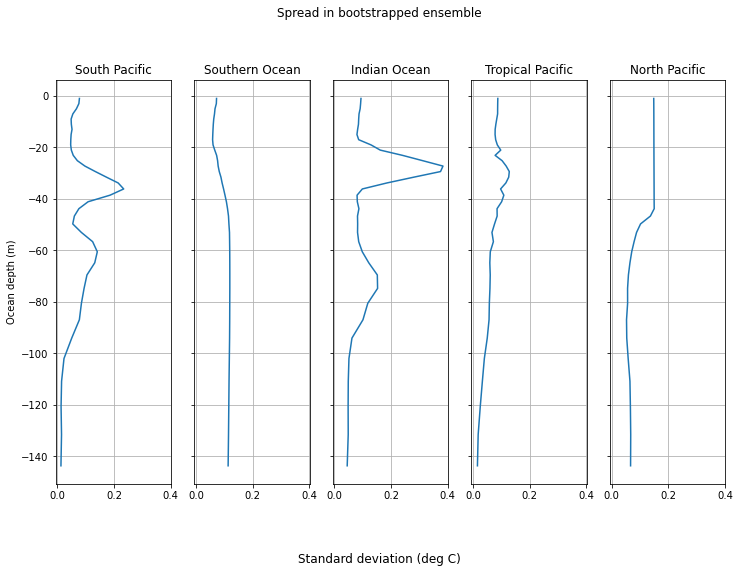

In [349]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot ocn temperature
ind0m = 64
ind150m =  37 
axs[0].plot(sp_spread[ind0m:ind0m+ind150m], -1 * sp_corr['ocn_lev'][:ind150m])
axs[1].plot(so_spread[ind0m:ind0m+ind150m], -1 * so_corr['ocn_lev'][:ind150m])
axs[2].plot(io_spread[ind0m:ind0m+ind150m], -1 * io_corr['ocn_lev'][:ind150m])
axs[3].plot(tp_spread[ind0m:ind0m+ind150m], -1 * tp_corr['ocn_lev'][:ind150m])
axs[4].plot(np_spread[ind0m:ind0m+ind150m], -1 * np_corr['ocn_lev'][:ind150m])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread in bootstrapped ensemble')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_spread_ocn150m_five_columns')
plt.show()

In [353]:
## Plot vertical profiles in atmosphere
## Average over ensemble members and show the mean at each location only

# South Pacific
sp_atm_temp = south_pacific['atm_T'].mean('ens_mem').to_numpy()
sp_atm_temp = sp_atm_temp.reshape(64, 25)

# Southern Ocean
so_atm_temp = southern_ocean['atm_T'].mean('ens_mem').to_numpy()
so_atm_temp = so_atm_temp.reshape(64, 25)

# Indian Ocean
io_atm_temp = indian_ocean['atm_T'].mean('ens_mem').to_numpy()
io_atm_temp = io_atm_temp.reshape(64, 25)

# Tropical Pacific
tp_atm_temp = tropical_pacific['atm_T'].mean('ens_mem').to_numpy()
tp_atm_temp = tp_atm_temp.reshape(64, 25)

# North Pacific
np_atm_temp = north_pacific['atm_T'].mean('ens_mem').to_numpy()
np_atm_temp = np_atm_temp.reshape(64, 25)

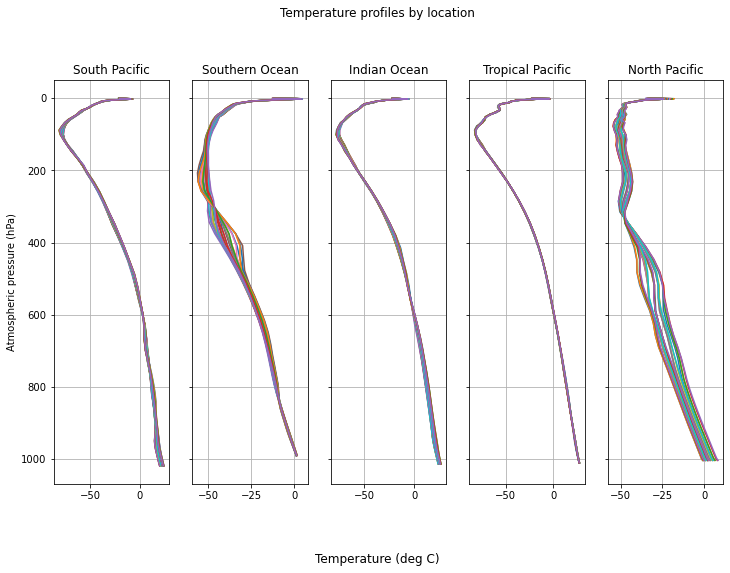

In [374]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True) 

# Plot atm temperature

axs[0].plot(sp_atm_temp - 273.15, sp_corr['atm_p'])
axs[1].plot(so_atm_temp - 273.15, so_corr['atm_p'])
axs[2].plot(io_atm_temp - 273.15, io_corr['atm_p'])
axs[3].plot(tp_atm_temp - 273.15, tp_corr['atm_p'])
axs[4].plot(np_atm_temp - 273.15, np_corr['atm_p'])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
#axs[0].set_yscale('log')
plt.gca().invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Temperature (deg C)')
fig.suptitle('Temperature profiles by location')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)
    

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_mean_atm_five_columns')
plt.show()

In [376]:
## Plot spread in top 150 m of ocean
## Standard deviation of ensemble

# South Pacific
sp_atm_temp_std = south_pacific['atm_T'].std('ens_mem').to_numpy()
sp_atm_temp_std = sp_atm_temp_std.reshape(64, 25)

# Southern Ocean
so_atm_temp_std = southern_ocean['atm_T'].std('ens_mem').to_numpy()
so_atm_temp_std = so_atm_temp_std.reshape(64, 25)

# Indian Ocean
io_atm_temp_std = indian_ocean['atm_T'].std('ens_mem').to_numpy()
io_atm_temp_std = io_atm_temp_std.reshape(64, 25)

# Tropical Pacific
tp_atm_temp_std = tropical_pacific['atm_T'].std('ens_mem').to_numpy()
tp_atm_temp_std = tp_atm_temp_std.reshape(64, 25)

# North Pacific
np_atm_temp_std = north_pacific['atm_T'].std('ens_mem').to_numpy()
np_atm_temp_std = np_atm_temp_std.reshape(64, 25)

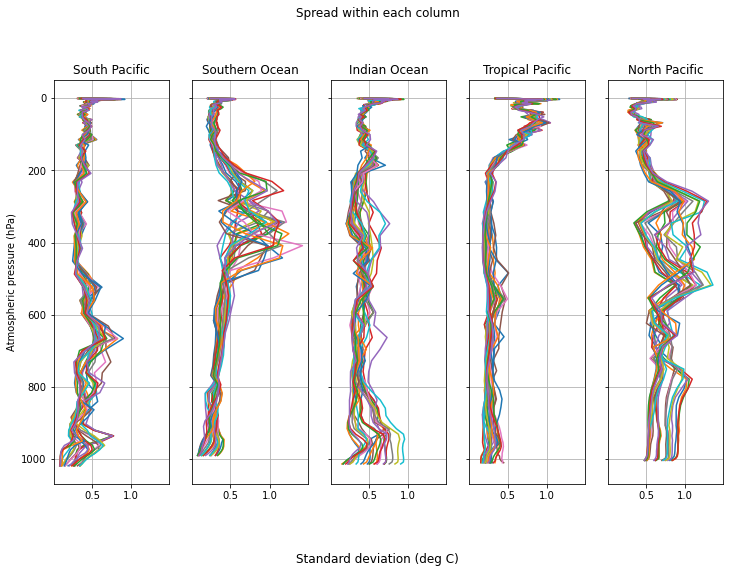

In [377]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot atm temperature spread
axs[0].plot(sp_atm_temp_std, sp_corr['atm_p'])
axs[1].plot(so_atm_temp_std, so_corr['atm_p'])
axs[2].plot(io_atm_temp_std, io_corr['atm_p'])
axs[3].plot(tp_atm_temp_std, tp_corr['atm_p'])
axs[4].plot(np_atm_temp_std, np_corr['atm_p'])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
plt.gca().invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread within each column')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_std_bycolumn_atm_five_columns')
plt.show()

In [378]:
# Spread in the mean profiles
sp_atm_stdofmean = sp_atm_temp.std(axis=1)
so_atm_stdofmean = so_atm_temp.std(axis=1)
io_atm_stdofmean = io_atm_temp.std(axis=1)
tp_atm_stdofmean = tp_atm_temp.std(axis=1)
np_atm_stdofmean = np_atm_temp.std(axis=1)

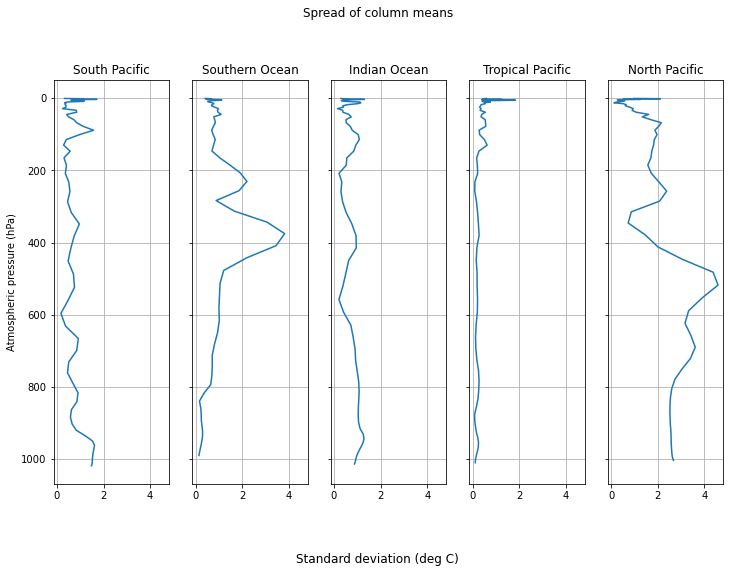

In [380]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot atm temperature spread of column means
axs[0].plot(sp_atm_stdofmean, sp_corr['atm_p'])
axs[1].plot(so_atm_stdofmean, so_corr['atm_p'])
axs[2].plot(io_atm_stdofmean, io_corr['atm_p'])
axs[3].plot(tp_atm_stdofmean, tp_corr['atm_p'])
axs[4].plot(np_atm_stdofmean, np_corr['atm_p'])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
plt.gca().invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread of column means')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_stdofmean_atm_five_columns')
plt.show()

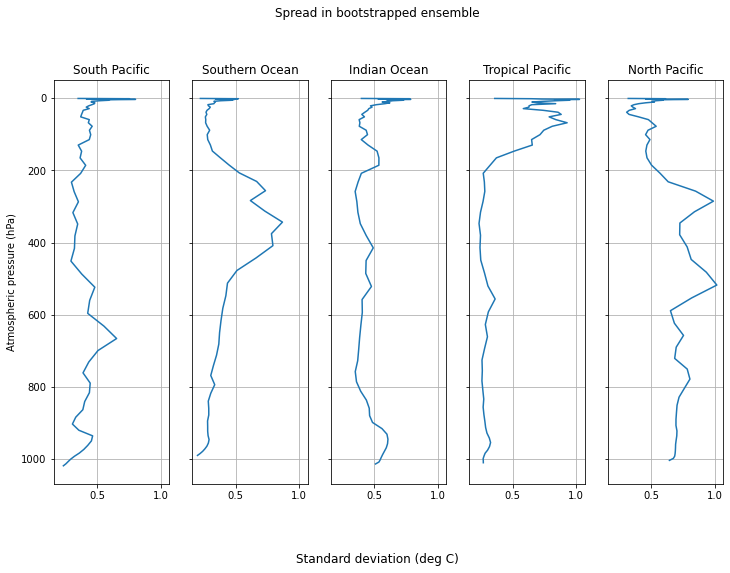

In [382]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot ocn temperature
ind0m = 64
axs[0].plot(sp_spread[:ind0m], sp_corr['atm_p'])
axs[1].plot(so_spread[:ind0m], so_corr['atm_p'])
axs[2].plot(io_spread[:ind0m], io_corr['atm_p'])
axs[3].plot(tp_spread[:ind0m], tp_corr['atm_p'])
axs[4].plot(np_spread[:ind0m], np_corr['atm_p'])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
plt.gca().invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Standard deviation (deg C)')
fig.suptitle('Spread in bootstrapped ensemble')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/temp_spread_atm_five_columns')
plt.show()

In [411]:
## Check to see if southern ocean is freshwater lens generated from ice melt 
## that creates a shallow barrier layer on the surface which makes the ocean more responsive
## to atm perts
so_salt_mean = southern_ocean['ocn_Salt'].sel(lon=45.5, lat=-59.5).mean(['ens_mem'])
so_temp_mean = southern_ocean['ocn_Temp'].sel(lon=45.5, lat=-59.5).mean(['ens_mem'])

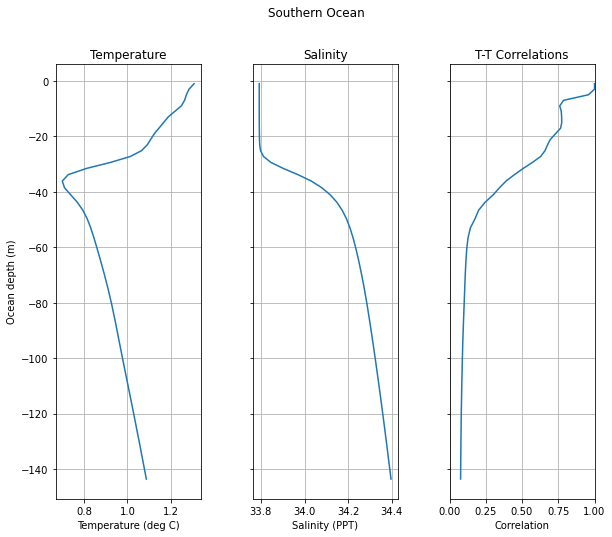

In [414]:
## Create subplots
fig, axs = plt.subplots(ncols=3, sharey=True) 

# Plot ocn states
ind150m =  37
axs[0].plot(so_temp_mean[:ind150m], -1 * sp_corr['ocn_lev'][:ind150m])
axs[1].plot(so_salt_mean[:ind150m], -1 * so_corr['ocn_lev'][:ind150m])
axs[2].plot(so_corr['sst_ocn_T'][:ind150m], -1 * io_corr['ocn_lev'][:ind150m])


# Set titles
axs[0].set_title('Temperature')
axs[1].set_title('Salinity')
axs[2].set_title('T-T Correlations')


# Adjust and label axes
axs[0].set_ylabel('Ocean depth (m)')
axs[0].set_xlabel('Temperature (deg C)')
axs[1].set_xlabel('Salinity (PPT)')
axs[2].set_xlabel('Correlation')
axs[2].set_xlim([0,1])
fig.suptitle('Southern Ocean')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3)

plt.rcParams['figure.figsize'] = [10,8]
plt.savefig(plot_dir+'/southern_ocean_temp_salt_corr')
plt.show()

In [422]:
## South Pacific
sp_corr = xr.Dataset()
sp_corr['ast_atm_T'] = xr.corr(south_pacific['atm_T'].sel(atm_lev=63), south_pacific['atm_T'], dim = 'ens_mem')
sp_corr['ast_ocn_T'] = xr.corr(south_pacific['atm_T'].sel(atm_lev=63), south_pacific['ocn_Temp'], dim = 'ens_mem')
sp_corr['atm_p'] = south_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
sp_corr = sp_corr.mean(['lat', 'lon'])

## Southern Ocean
so_corr = xr.Dataset()
so_corr['ast_atm_T'] = xr.corr(southern_ocean['atm_T'].sel(atm_lev=63), southern_ocean['atm_T'], dim = 'ens_mem')
so_corr['ast_ocn_T'] = xr.corr(southern_ocean['atm_T'].sel(atm_lev=63), southern_ocean['ocn_Temp'], dim = 'ens_mem')
so_corr['atm_p'] = southern_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
so_corr = so_corr.mean(['lat', 'lon'])

## Indian Ocean
io_corr = xr.Dataset()
io_corr['ast_atm_T'] = xr.corr(indian_ocean['atm_T'].sel(atm_lev=63), indian_ocean['atm_T'], dim = 'ens_mem')
io_corr['ast_ocn_T'] = xr.corr(indian_ocean['atm_T'].sel(atm_lev=63), indian_ocean['ocn_Temp'], dim = 'ens_mem')
io_corr['atm_p'] = indian_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
io_corr = io_corr.mean(['lat', 'lon'])

## Tropical Pacific
tp_corr = xr.Dataset()
tp_corr['ast_atm_T'] = xr.corr(tropical_pacific['atm_T'].sel(atm_lev=63), tropical_pacific['atm_T'], dim = 'ens_mem')
tp_corr['ast_ocn_T'] = xr.corr(tropical_pacific['atm_T'].sel(atm_lev=63), tropical_pacific['ocn_Temp'], dim = 'ens_mem')
tp_corr['atm_p'] = tropical_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
tp_corr = tp_corr.mean(['lat', 'lon'])

## North Pacific
np_corr = xr.Dataset()
np_corr['ast_atm_T'] = xr.corr(north_pacific['atm_T'].sel(atm_lev=63), north_pacific['atm_T'], dim = 'ens_mem')
np_corr['ast_ocn_T'] = xr.corr(north_pacific['atm_T'].sel(atm_lev=63), north_pacific['ocn_Temp'], dim = 'ens_mem')
np_corr['atm_p'] = north_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
np_corr = np_corr.mean(['lat', 'lon'])

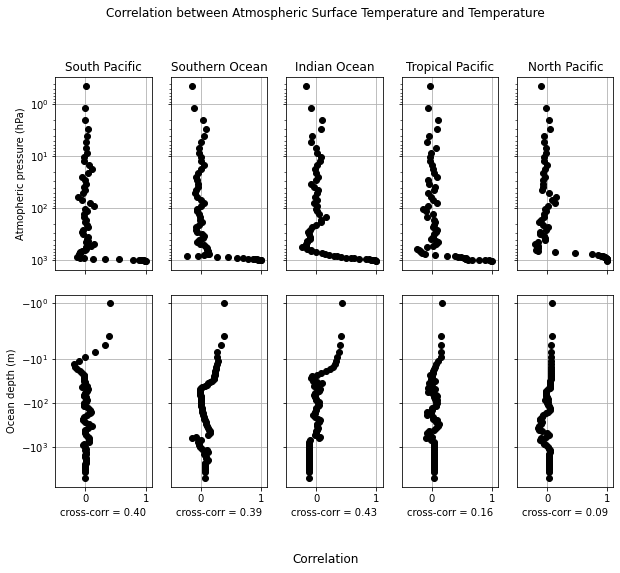

In [424]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='row') 

# Plot atm correlations
axs[0, 0].plot(sp_corr['ast_atm_T'], sp_corr['atm_p'], 'ko')
axs[0, 1].plot(so_corr['ast_atm_T'], so_corr['atm_p'], 'ko')
axs[0, 2].plot(io_corr['ast_atm_T'], io_corr['atm_p'], 'ko')
axs[0, 3].plot(tp_corr['ast_atm_T'], tp_corr['atm_p'], 'ko')
axs[0, 4].plot(np_corr['ast_atm_T'], np_corr['atm_p'], 'ko')

# Plot ocn correlations
axs[1, 0].plot(sp_corr['ast_ocn_T'], -1 * sp_corr['ocn_lev'], 'ko')
axs[1, 1].plot(so_corr['ast_ocn_T'], -1 * so_corr['ocn_lev'], 'ko')
axs[1, 2].plot(io_corr['ast_ocn_T'], -1 * io_corr['ocn_lev'], 'ko')
axs[1, 3].plot(tp_corr['ast_ocn_T'], -1 * tp_corr['ocn_lev'], 'ko')
axs[1, 4].plot(np_corr['ast_ocn_T'], -1 * np_corr['ocn_lev'], 'ko')

# Set titles
axs[0,0].set_title('South Pacific')
axs[0,1].set_title('Southern Ocean')
axs[0,2].set_title('Indian Ocean')
axs[0,3].set_title('Tropical Pacific')
axs[0,4].set_title('North Pacific')

# Add correlation
axs[1,0].set_xlabel('cross-corr = '+str('%.2f'%sp_corr['ast_ocn_T'][0].values))
axs[1,1].set_xlabel('cross-corr = '+str('%.2f'%so_corr['ast_ocn_T'][0].values))
axs[1,2].set_xlabel('cross-corr = '+str('%.2f'%io_corr['ast_ocn_T'][0].values))
axs[1,3].set_xlabel('cross-corr = '+str('%.2f'%tp_corr['ast_ocn_T'][0].values))
axs[1,4].set_xlabel('cross-corr = '+str('%.2f'%np_corr['ast_ocn_T'][0].values))

# Adjust axes
axs[0, 0].invert_yaxis()
axs[0, 0].set_yscale('log')
axs[1, 0].set_yscale('symlog')

# Adjust and label axes
axs[0, 0].set_xlim([-0.5, 1.1])
axs[0, 0].set_ylabel('Atmopheric pressure (hPa)')
axs[1, 0].set_ylabel('Ocean depth (m)')
fig.supxlabel('Correlation')
fig.suptitle('Correlation between Atmospheric Surface Temperature and Temperature')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ast_temp_corr_five_columns')
plt.show()